In [3]:
from pathlib import Path
import re
import os
import warnings

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from scipy import stats
import pyarrow as pa
import pyarrow.csv as csv
import pyarrow.compute as pc
import xarray as xr

In [4]:
ep_path = Path("/Volumes/TempData/Bretfeld Mario/Chimney-Park-Reprocessing-Sandbox/Alex Work/Good/Chimney/EC Processing/BB-NF/Fast/17m/EP")

In [9]:
fluxnet = pd.read_csv(ep_path / "eddypro_run1_fluxnet_2022-07-25T122059_adv.csv")
fullout = pd.read_csv(ep_path / "eddypro_run1_full_output_2022-07-25T122059_adv.csv")
metadata = pd.read_csv(ep_path / "eddypro_run1_metadata_2022-07-25T122059_adv.csv")

In [10]:
snow_path = Path('/Volumes/TempData/Bretfeld Mario/Chimney/Data/BB-NF/Snow')
burba_files = snow_path.glob('202*/23311Birba*.dat')
df = pd.concat([pd.read_csv(fn, skiprows=[0, 2, 3]) for fn in burba_files])
df.set_index('TIMESTAMP', inplace=True)
df.sort_index(inplace=True)
burba_df = df[['Birba_T_C_Avg(1)', 'Birba_T_C_Avg(2)', 'Birba_T_C_Avg(3)', 'Birba_T_C_Avg(4)']]
burba_df = burba_df.rename(columns={'Birba_T_C_Avg(1)':'T1', 'Birba_T_C_Avg(2)':'T2', 'Birba_T_C_Avg(3)':'T3', 'Birba_T_C_Avg(4)':'T4'})

In [64]:
biomet_df = pd.read_csv('/Volumes/TempData/Bretfeld Mario/Chimney/Data/BB-NF/EC/17m/Met30/TOA5_9809.Met30Min1.dat', skiprows=[0, 2, 3], na_values='NAN').set_index('TIMESTAMP')

In [100]:
df = biomet_df.merge(burba_df, left_index=True, right_index=True)

In [101]:
flux_summ = pd.read_csv('/Volumes/TempData/Bretfeld Mario/Chimney/Data/BB-NF/EC/17m/Met30/TOA5_9809.Flux30Min 2.dat', skiprows=[0, 2, 3], na_values='NAN')
flux_summ['WS'] = np.sqrt(flux_summ['Ux_CSAT3_17m_Avg']**2 + flux_summ['Uy_CSAT3_17m_Avg']**2)
flux_summ.set_index('TIMESTAMP', inplace=True)

In [102]:
df = df.merge(flux_summ, left_index=True, right_index=True)

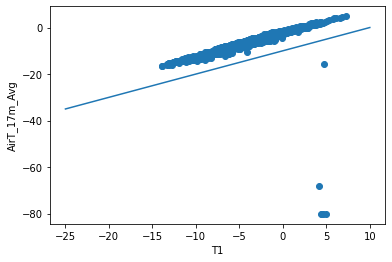

In [103]:
plt.scatter(df['T1'], df['AirT_17m_Avg'])
plt.ylabel('AirT_17m_Avg')
plt.xlabel('T1')
plt.plot([-25, 10], [-25 - 10, 10 - 10])

In [104]:
df.loc[df['AirT_17m_Avg'] < df['T1'] - 10, 'AirT_17m_Avg'] = np.nan
df.dropna(inplace=True)
df = df.loc[df['SWD_Avg'] <= 0]

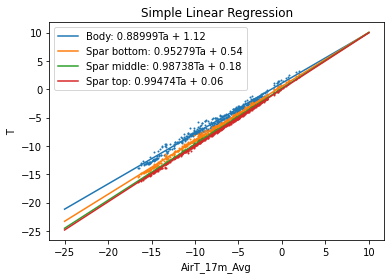

In [105]:


x = np.linspace(-25, 10, 5)
plt.plot(df['AirT_17m_Avg'], df[['T1', 'T2', 'T3', 'T4']], 'o', markersize=1)

slope, intercept, _, _, _ = stats.linregress(df['AirT_17m_Avg'], df['T1'])
plt.plot(x, slope*x + intercept, c='C0', label=f'Body: {slope:.5f}Ta + {intercept:.2f}')
slope, intercept, _, _, _ = stats.linregress(df['AirT_17m_Avg'], df['T2'])
plt.plot(x, slope*x + intercept, c='C1', label=f'Spar bottom: {slope:.5f}Ta + {intercept:.2f}')
slope, intercept, _, _, _ = stats.linregress(df['AirT_17m_Avg'], df['T3'])
plt.plot(x, slope*x + intercept, c='C2', label=f'Spar middle: {slope:.5f}Ta + {intercept:.2f}')
slope, intercept, _, _, _ = stats.linregress(df['AirT_17m_Avg'], df['T4'])
plt.plot(x, slope*x + intercept, c='C3', label=f'Spar top: {slope:.5f}Ta + {intercept:.2f}')

plt.legend()
plt.xlabel('AirT_17m_Avg')
plt.ylabel('T')
plt.title('Simple Linear Regression');

In [107]:
(0.18+0.54)/2

0.36

In [17]:
df['LWU_cor_Avg'] = df['LWU_cor_Avg'] + 5.67e-8*(-df['Tb_Avg']**4 + (df['Tb_Avg'] + 273.15)**4)

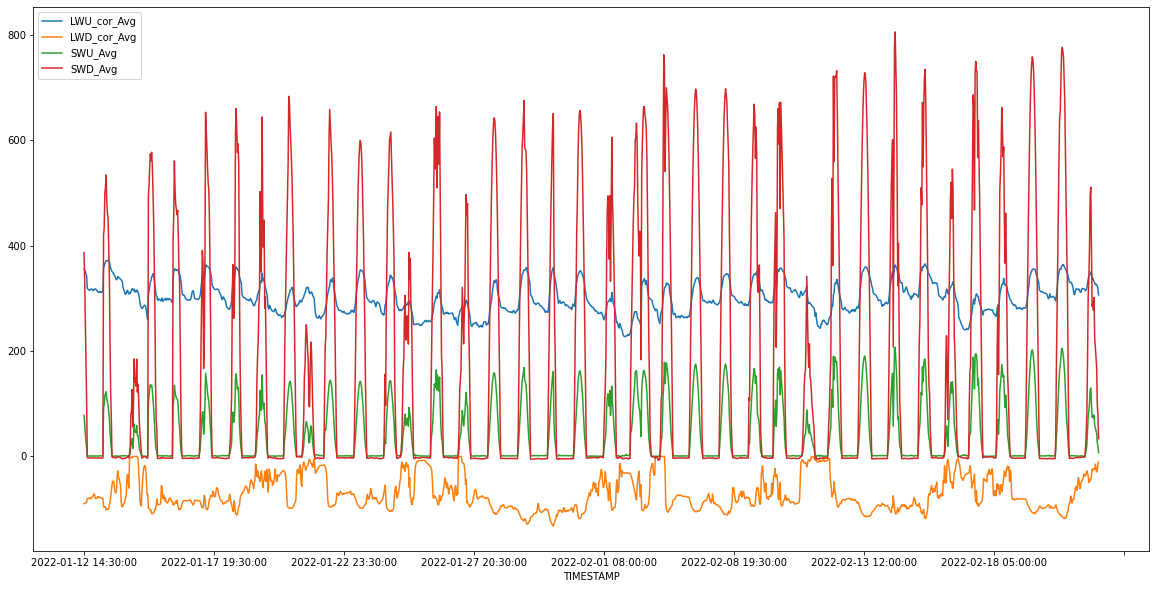

In [18]:
df[['LWU_cor_Avg', 'LWD_cor_Avg', 'SWU_Avg', 'SWD_Avg']].plot(figsize=(20,10));

In [47]:
from sklearn import linear_model

In [83]:
mlr = linear_model.LinearRegression().fit(df[['T1', 'T2', 'T3', 'T4']], df['T1'] - df['AirT_17m_Avg'])
mlr.coef_
# mlr.intercept_

array([ 1.06483964,  0.94239644, -3.8173582 ,  1.83055228])

In [25]:
df['T1_diff'] = df['T1'] - df['AirT_17m_Avg']
df['T2_diff'] = df['T2'] - df['AirT_17m_Avg']
df['T3_diff'] = df['T3'] - df['AirT_17m_Avg']
df['T4_diff'] = df['T4'] - df['AirT_17m_Avg']
df['TA'] = df['AirT_17m_Avg']
reg_df = df[['T1_diff', 'T2_diff', 'T3_diff', 'T4_diff', 'TA', 'LWD_cor_Avg', 'LWU_cor_Avg', 'SWD_Avg', 'SWU_Avg', 'WS']]

In [45]:
reg_df_day = reg_df.loc[reg_df['SWD_Avg'] > 0]
reg_df_night = reg_df.loc[reg_df['SWD_Avg'] <= 0]

In [63]:
biomet_df = df[['AirT_17m_Avg', '']]

,RECORD,AirT_17m_Avg,AirT_12m_Avg,AirT_7m_Avg,AirT_17m_Min,AirT_12m_Min,AirT_7m_Min,AirT_17m_Max,AirT_12m_Max,AirT_7m_Max,...,Rn_Avg,Rn_Std,PAR_up_17m_Avg,PAR_up_17m_Std,PAR_dn_17m_Avg,PAR_dn_17m_Std,T_CR3000_Avg,T_CR3000_Std,V_CR3000_Avg,V_CR3000_Min
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2021-08-17 04:30:00,16885,12.19286,11.57739,11.21345,12.12220,11.47498,10.90219,12.28310,11.65757,11.38513,...,-81.43890,0.650279,0.499232,1.959305,0.301904,1.157641,10.264400,0.097975,12.12749,12.07585
2021-08-17 05:00:00,16886,12.20703,11.58831,11.27575,12.02565,11.44162,11.16017,12.41920,11.78053,11.40888,...,-81.57130,0.683803,1.485071,3.536541,0.589741,1.618258,10.051040,0.040493,12.08299,12.07148
2021-08-17 05:30:00,16887,12.55237,11.90596,11.55387,12.38890,11.75204,11.24715,12.69957,12.04107,11.85682,...,-78.62156,3.712035,5.967621,5.591023,0.610521,1.445158,9.946910,0.017931,12.07637,12.06619
2021-08-17 06:00:00,16888,12.64649,12.20573,11.65265,12.48248,12.01612,11.38070,12.83482,12.71621,12.29403,...,-46.33018,14.549550,37.825890,15.906030,2.176141,2.081527,9.920289,0.005018,12.07885,12.05691
2021-08-17 06:30:00,16889,13.19923,13.29654,13.02655,12.80680,12.70296,12.26423,13.80080,14.00111,13.78257,...,14.19146,20.718280,104.556300,22.432410,4.552829,2.719533,10.105480,0.138190,12.09895,12.07079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-15 09:00:00,2348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-15 09:30:00,2349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-15 10:00:00,2350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Daytime
# T - Ta ~ Ta + SWin + U
# body
day_mlr_body = linear_model.LinearRegression().fit(reg_df[['TA', 'SWD_Avg', 'WS']], reg_df['T1_diff'])
day_mlr_body.coef_, day_mlr_body.intercept_

print(f'Daytime Bottom: Tbot - Ta = {day_mlr_body.intercept_:.5f} + {day_mlr_body.coef_[0]:.5f}Ta + {day_mlr_body.coef_[1]:.5f}Rg + {day_mlr_body.coef_[2]:.5f}U')

# head
day_mlr_head = linear_model.LinearRegression().fit(reg_df[['TA', 'SWD_Avg', 'WS']], reg_df['T4_diff'])
day_mlr_head.coef_, day_mlr_head.intercept_

print(f'Daytime Top: Tbot - Ta = {day_mlr_head.intercept_:.5f} + {day_mlr_head.coef_[0]:.5f}Ta + {day_mlr_head.coef_[1]:.5f}Rg + {day_mlr_head.coef_[2]:.5f}U')

# spar
day_mlr_spar = linear_model.LinearRegression().fit(reg_df[['TA', 'SWD_Avg', 'WS']], (reg_df['T2_diff'] + reg_df['T3_diff'])/2)
day_mlr_spar.coef_, day_mlr_spar.intercept_

print(f'Daytime Spar: Tbot - Ta = {day_mlr_spar.intercept_:.5f} + {day_mlr_spar.coef_[0]:.5f}Ta + {day_mlr_spar.coef_[1]:.5f}Rg + {day_mlr_spar.coef_[2]:.5f}U')

Daytime Bottom: Tbot - Ta = 2.97039 + -0.07704Ta + 0.00267Rg + -0.47678U
Daytime Top: Tbot - Ta = 0.33025 + -0.00645Ta + 0.00156Rg + -0.07106U
Daytime Spar: Tbot - Ta = 1.14371 + -0.02394Ta + 0.00173Rg + -0.20823U


In [61]:
# Nighttime
# T - Ta ~ Ta + LWin + U

# body
night_mlr_body = linear_model.LinearRegression().fit(reg_df[['TA', 'LWD_cor_Avg', 'WS']], reg_df['T1_diff'])
print(f'Nighttime Bottom: Tbot - Ta = {night_mlr_body.intercept_:.5f} + {night_mlr_body.coef_[0]:.5f}Ta + {night_mlr_body.coef_[1]:.5f}LWin + {night_mlr_body.coef_[2]:.5f}U')

# head
night_mlr_head = linear_model.LinearRegression().fit(reg_df[['TA', 'LWD_cor_Avg', 'WS']], reg_df['T4_diff'])
print(f'Nighttime Head: Tbot - Ta = {night_mlr_head.intercept_:.5f} + {night_mlr_head.coef_[0]:.5f}Ta + {night_mlr_head.coef_[1]:.5f}LWin + {night_mlr_head.coef_[2]:.5f}U')

# spar
night_mlr_spar = linear_model.LinearRegression().fit(reg_df[['TA', 'LWD_cor_Avg', 'WS']], (reg_df['T2_diff'] + reg_df['T3_diff'])/2)
print(f'Nighttime Spar: Tbot - Ta = {night_mlr_spar.intercept_:.5f} + {night_mlr_spar.coef_[0]:.5f}Ta + {night_mlr_spar.coef_[1]:.5f}LWin + {night_mlr_spar.coef_[2]:.5f}U')




Nighttime Bottom: Tbot - Ta = 3.56683 + -0.02560Ta + 0.00380LWin + -0.35448U
Nighttime Bottom: Tbot - Ta = 0.65320 + 0.02229Ta + 0.00178LWin + -0.00417U
Nighttime Bottom: Tbot - Ta = 1.51186 + 0.00845Ta + 0.00215LWin + -0.13226U


In [71]:
list(df.columns)

['RECORD_x',
 'AirT_17m_Avg',
 'AirT_12m_Avg',
 'AirT_7m_Avg',
 'AirT_17m_Min',
 'AirT_12m_Min',
 'AirT_7m_Min',
 'AirT_17m_Max',
 'AirT_12m_Max',
 'AirT_7m_Max',
 'AirT_17m_Std',
 'AirT_12m_Std',
 'AirT_7m_Std',
 'RH_17m',
 'RH_12m',
 'RH_7m',
 'RH_17m_Min',
 'RH_12m_Min',
 'RH_7m_Min',
 'RH_17m_Max',
 'RH_12m_Max',
 'RH_7m_Max',
 'RH_17m_Std',
 'RH_12m_Std',
 'RH_7m_Std',
 'WS_12m_Avg',
 'WS_12m_Med',
 'WS_12m_Min',
 'WS_12m_Max',
 'WS_12m_Std',
 'WD_12m',
 'SurfT_canopy_Avg',
 'SurfT_canopy_Min',
 'SurfT_canopy_Max',
 'SurfT_canopy_Std',
 'SBT_C_Avg',
 'SBT_C_Min',
 'SBT_C_Max',
 'SBT_C_Std',
 'SWD_Avg',
 'SWD_Std',
 'SWU_Avg',
 'SWU_Std',
 'LWD_cor_Avg',
 'LWD_cor_Std',
 'LWU_cor_Avg',
 'LWU_cor_Std',
 'Tb_Avg',
 'Tb_Std',
 'albedo_Avg',
 'albedo_Std',
 'Rn_Avg',
 'Rn_Std',
 'PAR_up_17m_Avg',
 'PAR_up_17m_Std',
 'PAR_dn_17m_Avg',
 'PAR_dn_17m_Std',
 'T_CR3000_Avg_x',
 'T_CR3000_Std_x',
 'V_CR3000_Avg_x',
 'V_CR3000_Min',
 'T1',
 'T2',
 'T3',
 'T4',
 'RECORD_y',
 'n_Tot',
 'Ux_CSAT3

In [94]:
df_biomet = df[['AirT_17m_Avg', 'P_LI7500_Std', 'RH_17m', 'SurfT_canopy_Avg', 'AirT_7m_Avg', 'SWD_Avg', 'Rn_Avg', 'LWD_cor_Avg', 'LWU_cor_Avg', 'SWD_Avg', 'SWU_Avg', 'PAR_up_17m_Avg']]
df_biomet.reset_index(inplace=True)
df_biomet.loc[:,'TIMESTAMP'] = ["".join(ts.split(":")[:-1]) for ts in list(df_biomet['TIMESTAMP'].astype(str))]
df_biomet.to_csv()

,TIMESTAMP,AirT_17m_Avg,P_LI7500_Std,RH_17m,SurfT_canopy_Avg,AirT_7m_Avg,SWD_Avg,Rn_Avg,LWD_cor_Avg,LWU_cor_Avg,SWD_Avg,SWU_Avg,PAR_up_17m_Avg
0,2022-01-12 1430,-0.195891,0.026301,54.67701,-0.858301,0.662028,386.8366,223.722300,-90.01738,-4.572190,386.8366,77.66918,372.10570
1,2022-01-12 1500,0.127795,0.030733,57.03630,-0.780291,0.709711,332.2214,188.598400,-89.37687,-5.404671,332.2214,59.65084,317.46830
2,2022-01-12 1530,0.148177,0.022321,59.06512,-0.968097,0.586393,254.2042,131.595000,-89.20916,-6.630355,254.2042,40.03033,241.99570
3,2022-01-12 1600,-0.174478,0.017740,59.43070,-1.553169,0.060975,186.6894,79.242740,-88.54089,-7.469976,186.6894,26.37577,175.80780
4,2022-01-12 1630,-0.629526,0.017656,59.03664,-2.346088,-0.514518,101.0438,7.472736,-86.62463,-8.381233,101.0438,15.32764,91.67442
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2022-01-31 0900,-5.124309,0.031593,18.21927,-7.141900,-4.990635,257.7899,116.096100,-91.55217,-8.129682,257.7899,58.27127,232.48620
756,2022-01-31 0930,-2.499262,0.022180,19.07608,-4.130532,-1.922323,312.0618,157.261100,-92.06803,-9.971739,312.0618,72.70445,291.59720
757,2022-01-31 1000,-2.809952,0.023070,19.68247,-4.115960,-2.046746,423.6724,241.469000,-94.38152,-8.602890,423.6724,96.42483,399.90820
758,2022-01-31 1030,-1.738215,0.021631,18.91630,-3.138963,-0.816021,483.8183,273.353400,-103.52970,-7.794804,483.8183,114.73000,458.38150


['2022-01-12 1430',
 '2022-01-12 1500',
 '2022-01-12 1530',
 '2022-01-12 1600',
 '2022-01-12 1630',
 '2022-01-12 1730',
 '2022-01-12 1800',
 '2022-01-12 1830',
 '2022-01-12 1900',
 '2022-01-12 1930',
 '2022-01-12 2000',
 '2022-01-12 2030',
 '2022-01-12 2100',
 '2022-01-12 2130',
 '2022-01-12 2200',
 '2022-01-12 2230',
 '2022-01-12 2300',
 '2022-01-12 2330',
 '2022-01-13 0000',
 '2022-01-13 0030',
 '2022-01-13 0100',
 '2022-01-13 0130',
 '2022-01-13 0200',
 '2022-01-13 0230',
 '2022-01-13 0300',
 '2022-01-13 0330',
 '2022-01-13 0400',
 '2022-01-13 0430',
 '2022-01-13 0500',
 '2022-01-13 0530',
 '2022-01-13 1030',
 '2022-01-13 1100',
 '2022-01-13 1130',
 '2022-01-13 1200',
 '2022-01-13 1230',
 '2022-01-13 1300',
 '2022-01-13 1330',
 '2022-01-13 1400',
 '2022-01-13 1430',
 '2022-01-13 1500',
 '2022-01-13 1530',
 '2022-01-13 1600',
 '2022-01-13 1630',
 '2022-01-13 1730',
 '2022-01-13 1800',
 '2022-01-13 1830',
 '2022-01-13 1900',
 '2022-01-13 1930',
 '2022-01-13 2000',
 '2022-01-13 2030',
